**Project Pipeline**

# Plan
   - Goals:
        1. predict values of single unit properties that have been assessed by the tax district during the months of May and june 2017
        2. Identify what states and counties each property is located
        3. Identify the distribution of tax rates for each county  __NOTE:__ this will be not be used to build out our models

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, ttest_ind, pearsonr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm


import env
import acquire
import prep
import split_scale
import model


# Aquire  

## create query so we can accees the Zillow table in SQL
  

In [ ]:
# Here is the SQL query used
# query = '''
#     SELECT
#     prop.parcelid,
#     bathroomcnt AS bathrooms,
#     bedroomcnt AS bedrooms,
#     calculatedfinishedsquarefeet AS square_feet,
#     fips AS fips_number,
#     ptype.propertylandusetypeid,
#     ptype.propertylandusedesc,
#     taxvaluedollarcnt AS home_value,
#     taxamount AS tax_amount
#     FROM properties_2017 AS prop
#         JOIN
#         predictions_2017 AS pred
#         ON prop.parcelid = pred.parcelid
#         JOIN
#         propertylandusetype AS ptype
#         ON prop.propertylandusetypeid = ptype.propertylandusetypeid

#     WHERE transactiondate
#     BETWEEN '2017-05-01' AND '2017-06-30' AND propertylandusedesc = 'Single Family Residential'

## Pull data into jupyter notebook and create a Pandas DataFrame
   

In [2]:
df = acquire.get_zillow_data_from_sql()
df.head()

,parcelid,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount
0,11289917,2.0,3.0,1458.0,6037.0,261,Single Family Residential,136104.0,2319.90
1,11705026,1.0,2.0,1421.0,6037.0,261,Single Family Residential,35606.0,543.69
2,14269464,3.0,4.0,2541.0,6059.0,261,Single Family Residential,880456.0,9819.72
3,11389003,2.0,3.0,1650.0,6037.0,261,Single Family Residential,614000.0,7673.19
4,11967869,1.0,2.0,693.0,6037.0,261,Single Family Residential,274237.0,3267.47


# Prepare Data

## Dive into the data
  - df.head()
  - df.dtypes
  - df.columns
  - df.shape

In [3]:
df.head()

,parcelid,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount
0,11289917,2.0,3.0,1458.0,6037.0,261,Single Family Residential,136104.0,2319.90
1,11705026,1.0,2.0,1421.0,6037.0,261,Single Family Residential,35606.0,543.69
2,14269464,3.0,4.0,2541.0,6059.0,261,Single Family Residential,880456.0,9819.72
3,11389003,2.0,3.0,1650.0,6037.0,261,Single Family Residential,614000.0,7673.19
4,11967869,1.0,2.0,693.0,6037.0,261,Single Family Residential,274237.0,3267.47


In [4]:
df.dtypes

parcelid                   int64
bathrooms                float64
bedrooms                 float64
square_feet              float64
fips_number              float64
propertylandusetypeid      int64
propertylandusedesc       object
home_value               float64
tax_amount               float64
dtype: object

In [5]:
df.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'square_feet', 'fips_number',
       'propertylandusetypeid', 'propertylandusedesc', 'home_value',
       'tax_amount'],
      dtype='object')

In [6]:
df.shape

(15036, 9)

## Prep the data
  - df.isnull().sum()
  - create a prep.py file to use in cleaning the data
  - use function `clean_data` from `prep.py` to drop nulls
  - I chose to set the index to parcel id because each property has a unqiue number
  - plot the distributions of the independent variables
      - Independent variables are controlled inputs and we will use these types of variables to study the effect they have on the dependent variable

In [7]:
df.isnull().sum()

parcelid                  0
bathrooms                 0
bedrooms                  0
square_feet              24
fips_number               0
propertylandusetypeid     0
propertylandusedesc       0
home_value                0
tax_amount                1
dtype: int64

__It is important to use different variables when changing the dataframe to ensure you are using the correct data__

In [8]:
df_clean = prep.clean_data(df)
## verify nulls are gone
df_clean.isnull().sum()

parcelid                 0
bathrooms                0
bedrooms                 0
square_feet              0
fips_number              0
propertylandusetypeid    0
propertylandusedesc      0
home_value               0
tax_amount               0
dtype: int64

In [9]:
df_clean.shape

(15011, 9)

In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15011 entries, 0 to 15035
Data columns (total 9 columns):
parcelid                 15011 non-null int64
bathrooms                15011 non-null float64
bedrooms                 15011 non-null float64
square_feet              15011 non-null float64
fips_number              15011 non-null float64
propertylandusetypeid    15011 non-null int64
propertylandusedesc      15011 non-null object
home_value               15011 non-null float64
tax_amount               15011 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.1+ MB


In [11]:
# we need to change some data types and we also need to set an index id sp for the
# writing I am changing df_clean back to the variable name df
df = df_clean .set_index(['parcelid'])

# changing data types

df = df.astype({'propertylandusedesc': 'category',
               'fips_number': 'int'})

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15011 entries, 11289917 to 11464823
Data columns (total 8 columns):
bathrooms                15011 non-null float64
bedrooms                 15011 non-null float64
square_feet              15011 non-null float64
fips_number              15011 non-null int64
propertylandusetypeid    15011 non-null int64
propertylandusedesc      15011 non-null category
home_value               15011 non-null float64
tax_amount               15011 non-null float64
dtypes: category(1), float64(5), int64(2)
memory usage: 952.9 KB


In [12]:
df.head()

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount
parcelid,,,,,,,,
11289917,2.0,3.0,1458.0,6037,261,Single Family Residential,136104.0,2319.9
11705026,1.0,2.0,1421.0,6037,261,Single Family Residential,35606.0,543.7
14269464,3.0,4.0,2541.0,6059,261,Single Family Residential,880456.0,9819.7
11389003,2.0,3.0,1650.0,6037,261,Single Family Residential,614000.0,7673.2
11967869,1.0,2.0,693.0,6037,261,Single Family Residential,274237.0,3267.5


In [13]:
# add the county for each property based off the fips_number which came from o
# utside the dataframe. This tells what county each property is located in
df['county_name'] = df.fips_number.map({6037: 'Los Angeles', 
                                        6059: 'Orange',
                                        6111: 'Ventura'
                                       })

In [14]:
df.head(5)

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount,county_name
parcelid,,,,,,,,,
11289917,2.0,3.0,1458.0,6037,261,Single Family Residential,136104.0,2319.9,Los Angeles
11705026,1.0,2.0,1421.0,6037,261,Single Family Residential,35606.0,543.7,Los Angeles
14269464,3.0,4.0,2541.0,6059,261,Single Family Residential,880456.0,9819.7,Orange
11389003,2.0,3.0,1650.0,6037,261,Single Family Residential,614000.0,7673.2,Los Angeles
11967869,1.0,2.0,693.0,6037,261,Single Family Residential,274237.0,3267.5,Los Angeles


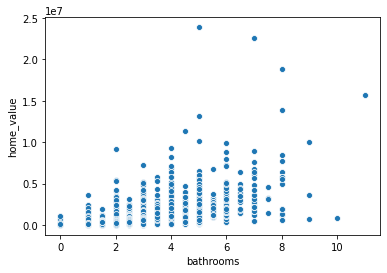

In [15]:
# plot

sns.scatterplot(x='bathrooms', y='home_value', data=df)


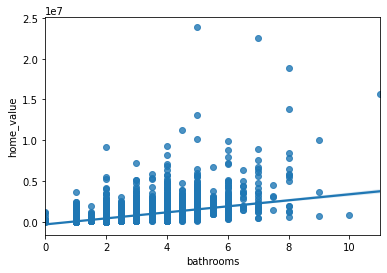

In [16]:
sns.regplot(x='bathrooms', y='home_value', data=df)


In [17]:
# need to drop some columns 
df = df.drop(columns=['fips_number', 'propertylandusetypeid', 'propertylandusedesc',
                 'tax_amount', 'county_name'])

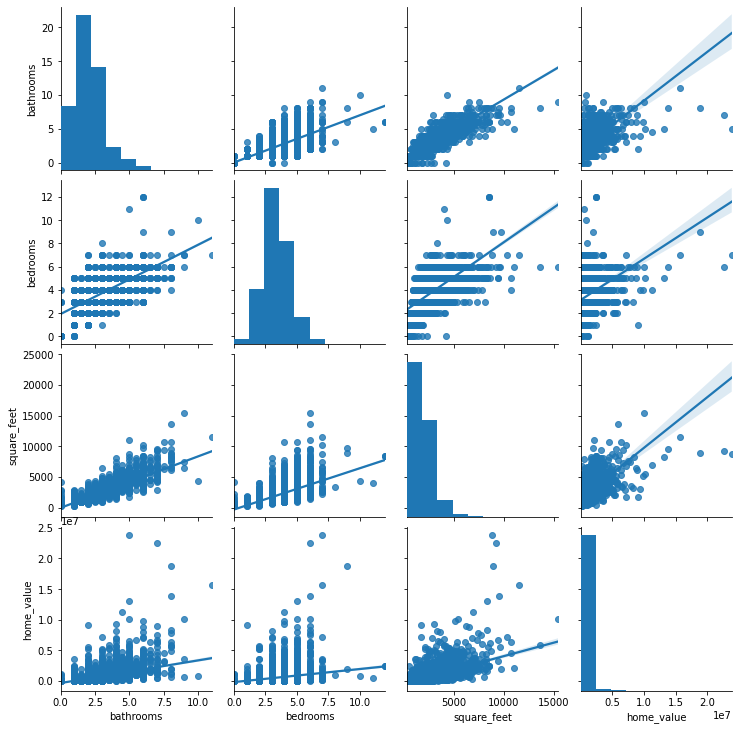

In [18]:
g = sns.pairplot(df, kind='reg')
g

## Split into train/test
  - separate attributes into new dataframe called X
  - separate y into its own dataframe
  - split X and y 
  

In [20]:
# Define X and y variables
X = df[['bathrooms', 'bedrooms', 'square_feet']]
y = df[['home_value']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=123)

In [24]:
X_train.head()

,bathrooms,bedrooms,square_feet
parcelid,,,
11713180,3.0,2.0,1736.0
10774370,3.0,3.0,1565.0
12279758,2.0,3.0,1334.0
14476387,2.0,2.0,1503.0
10719724,2.0,3.0,1372.0


# Step 4: Explore & Preprocess

1. Visualize Attributes and interactions
2. Anlyze: using statsmodels, numpy, scipy, scikit-learn
3. __Possible Deliverable Product__
    - report of analysis
    - presentation slide
4. Feature engineering
    - Zillow has chosen the features for us:
        - square feet of home
        - number of bedrooms
        - number of bathrooms
5. Summarize our takaways and conclusions

In [ ]:
df.hist(grid=False, figsize=(16,12))

In [ ]:
df.corr()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax=sns.heatmap(df.corr(), cmap = 'Blues', annot=True)

# Step 5: Modeling

1. Develop a regression model that performs better than a baseline
    - this can be accomplished using various algorithims and hyperparameters which will be needed before settling on the final algorithim
2. Evaluate model using standard techniques:
    - plotting the residuals
    - computing the evaluation metric:
        - SSE
        - RMSE
        - MSE if needed
    - compare to baseline
    - plotting $y$ by $\bar{y}$